# Demo of Bagging
An example modified from MachineLearningMastery

In [1]:
# bagging mlp ensemble on blobs dataset
from sklearn.datasets import make_blobs
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
import numpy
from numpy import array
from numpy import argmax
from pandas import DataFrame

In [2]:
numpy.random.seed(100)

In [3]:
# evaluate a single mlp model
def evaluate_model(trainX, trainy, testX, testy):
    # encode targets
    trainy_enc = to_categorical(trainy)
    testy_enc = to_categorical(testy)
    # define model
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit model
    model.fit(trainX, trainy_enc, epochs=50, verbose=0)
    # evaluate the model
    _, test_acc = model.evaluate(testX, testy_enc, verbose=0)
    return model, test_acc

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)
    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)
    # argmax across classes
    result = argmax(summed, axis=1)
    return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate accuracy
    return accuracy_score(testy, yhat)

### Visualize the data

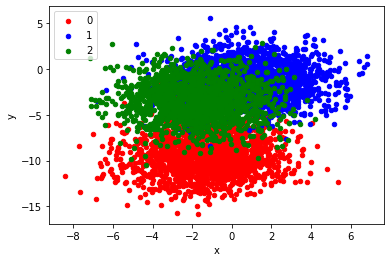

In [4]:
# generate 2d classification dataset
dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2, random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]

df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

### Train individual model

In [5]:
# multiple train-test splits
n_splits = 20
scores, members = list(), list()
for _ in range(n_splits):
    # select indexes
    ix = [i for i in range(len(X))]
    train_ix = resample(ix, replace=True, n_samples=4500)
    test_ix = [x for x in ix if x not in train_ix]
    # select data
    trainX, trainy = X[train_ix], y[train_ix]
    testX, testy = X[test_ix], y[test_ix]
    # evaluate model
    model, test_acc = evaluate_model(trainX, trainy, testX, testy)
    print('>%.3f' % test_acc)
    scores.append(test_acc)
    members.append(model)
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))

>0.838
>0.822
>0.802
>0.820
>0.833
>0.826
>0.829
>0.823
>0.823
>0.826
>0.832
>0.835
>0.838
>0.823
>0.820
>0.823
>0.818
>0.826
>0.822
>0.832
Estimated Accuracy 0.825 (0.008)


In [7]:
### evaluate different numbers of ensembles on hold out set

> 1: single=0.819, ensemble=0.819
> 2: single=0.820, ensemble=0.819
> 3: single=0.817, ensemble=0.820
> 4: single=0.819, ensemble=0.820
> 5: single=0.819, ensemble=0.820
> 6: single=0.819, ensemble=0.820
> 7: single=0.819, ensemble=0.820
> 8: single=0.819, ensemble=0.820
> 9: single=0.817, ensemble=0.820
> 10: single=0.819, ensemble=0.820
> 11: single=0.819, ensemble=0.820
> 12: single=0.819, ensemble=0.820
> 13: single=0.820, ensemble=0.820
> 14: single=0.820, ensemble=0.821
> 15: single=0.819, ensemble=0.820
> 16: single=0.819, ensemble=0.820
> 17: single=0.820, ensemble=0.820
> 18: single=0.819, ensemble=0.821
> 19: single=0.820, ensemble=0.821
> 20: single=0.817, ensemble=0.820
Accuracy 0.819 (0.001)


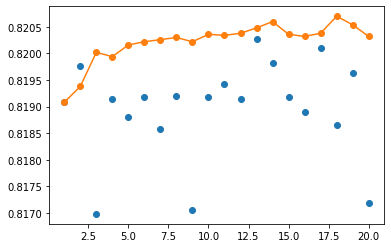

In [6]:
single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
    ensemble_score = evaluate_n_members(members, i, newX, newy)
    newy_enc = to_categorical(newy)
    _, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)
# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()